# ANALYTICAL FINANCE 2
## Project : Use data for SOFR on FRED to bootstrap a SOFR Swap-curve using Python.

This project aims to bootstrap a SOFR Swap-curve using using Python.

In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

In [2]:
API_KEY = pd.read_csv('.API_KEY.txt',sep=';', header=None)[1][0]
BASE_URL = 'https://api.stlouisfed.org/fred/series/observations'
series_ids_bootstrap = {'SOFRINDEX': 'SOFR Index accumulated',
                        'SOFR': 'SOFR Index',
                        'FEDFUNDS': 'Effective Federal Funds Rate',
                        'BC_1MONTH': '1-Month Treasury Bill: Secondary Market Rate',
                        'BC_2MONTH': '2-Month Treasury Bill: Secondary Market Rate',
                        'BC_3MONTH': '3-Month Treasury Bill: Secondary Market Rate',
                        'BC_6MONTH': '6-Month Treasury Bill: Secondary Market Rate',
                        'BC_1YEAR': '1-Year Treasury Bill: Secondary Market Rate', 
                        # 'DGS1': '1-Year Treasury Constant Maturity Rate',
                        # 'DGS5': '5-Year Treasury Constant Maturity Rate',
                        # 'DGS10': '10-Year Treasury Constant Maturity Rate',
}

def fetch_data(series_id):
    params = {
        'series_id': series_id,
        'api_key': API_KEY,
        'file_type': 'json',
        'frequency': 'd',  # daily frequency
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Series {series_id} not available at daily frequency, trying monthly")
        # Change frequency to monthly if daily data is not available for the series
        params = {
        'series_id': series_id,
        'api_key': API_KEY,
        'file_type': 'json',
        'frequency': 'm',  # monthly frequency
        }
        response = requests.get(BASE_URL, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching {series_id}: {response.status_code}")
        return None

# Fetch data for each indicator and store in a dictionary
data = {name: fetch_data(series_id) for series_id, name in series_ids_bootstrap.items()}

# Print the fetched data keys for quick inspection
for name, content in data.items():
    if content:
        print(f"{name} retrieved")  
    else:
        print(f"{name}: No data retrieved")


# Function to convert the fetched data into a DataFrame
def convert_to_df(content):
    if content:
        try:
            df = pd.DataFrame(content['observations'])
            df['date'] = pd.to_datetime(df['date'])
            df['value'].replace('.', np.nan, inplace=True)
            df['value'] = pd.to_numeric(df['value'])
            df = df.set_index('date')
            return df
        except Exception as e:
            print(f"Error converting to DataFrame: {e}")
            return None
    else:
        return None
    
# Convert the fetched data into DataFrames
dfs = {name: convert_to_df(content) for name, content in data.items()}

dfs = {name: content for name, content in dfs.items() if content is not None}

# correlation matrix
fic_data = []
fic_data.extend(df.value for df in dfs.values())
fic_data = pd.concat(fic_data, axis=1)
fic_data.columns = dfs.keys()
fic_data.ffill(inplace=True)
fic_data.dropna(inplace=True)

fic_data['d_o_n'] = fic_data.index.dayofweek == 4
fic_data['d_o_n'] = fic_data['d_o_n'].astype(int)
#replace Friday with 3 and other days with 1
fic_data['d_o_n'] = fic_data['d_o_n'].replace(1, 3)
fic_data.loc[fic_data['d_o_n'] == 0, 'd_o_n'] = 1
fic_data

Series FEDFUNDS not available at daily frequency, trying monthly
Series BC_1MONTH not available at daily frequency, trying monthly
Error fetching BC_1MONTH: 400
Series BC_2MONTH not available at daily frequency, trying monthly
Error fetching BC_2MONTH: 400
Series BC_3MONTH not available at daily frequency, trying monthly
Error fetching BC_3MONTH: 400
Series BC_6MONTH not available at daily frequency, trying monthly
Error fetching BC_6MONTH: 400
Series BC_1YEAR not available at daily frequency, trying monthly
Error fetching BC_1YEAR: 400
SOFR Index accumulated retrieved
SOFR Index retrieved
Effective Federal Funds Rate retrieved
1-Month Treasury Bill: Secondary Market Rate: No data retrieved
2-Month Treasury Bill: Secondary Market Rate: No data retrieved
3-Month Treasury Bill: Secondary Market Rate: No data retrieved
6-Month Treasury Bill: Secondary Market Rate: No data retrieved
1-Year Treasury Bill: Secondary Market Rate: No data retrieved


,SOFR Index accumulated,SOFR Index,Effective Federal Funds Rate,d_o_n
date,,,,
2018-04-03,1.000050,1.83,1.69,1
2018-04-04,1.000101,1.74,1.69,1
2018-04-05,1.000149,1.75,1.69,1
2018-04-06,1.000198,1.75,1.69,3
2018-04-09,1.000344,1.75,1.69,1
...,...,...,...,...
2024-10-09,1.162282,4.83,5.13,1
2024-10-10,1.162438,4.82,5.13,1
2024-10-11,1.162594,4.81,5.13,3


In [3]:
yield_curve_rate = pd.read_csv('data/yield-curve-rates-1990-2023.csv', sep=',')
yield_curve_rate['Date'] = pd.to_datetime(yield_curve_rate['Date'])
yield_curve_rate.set_index('Date', inplace=True)
yield_curve_rate.sort_index(inplace=True)

fic_data = pd.merge(fic_data, yield_curve_rate, left_index=True, right_index=True, how='inner')

In [4]:
fic_data.tail(5)

,SOFR Index accumulated,SOFR Index,Effective Federal Funds Rate,d_o_n,1 Mo,2 Mo,3 Mo,4 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
2023-12-22,1.113454,5.32,5.33,3,5.54,5.52,5.44,5.45,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05
2023-12-26,1.114112,5.35,5.33,1,5.53,5.52,5.45,5.44,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
2023-12-27,1.114278,5.39,5.33,1,5.55,5.53,5.44,5.42,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95
2023-12-28,1.114445,5.40,5.33,1,5.57,5.55,5.45,5.42,5.28,4.82,4.26,4.02,3.83,3.84,3.84,4.14,3.98
2023-12-29,1.114612,5.38,5.33,3,5.60,5.59,5.40,5.41,5.26,4.79,4.23,4.01,3.84,3.88,3.88,4.20,4.03


In [43]:
from copy import deepcopy
import numpy as np
import pandas as pd

df = deepcopy(fic_data)  # Assuming fic_data is the original dataset

# Function to calculate discount factor from simple interest rate
def discount_factor_simple_rate(rate, time_period):
    """
    Calculate the discount factor for a given time period using a simple interest rate.
    :param rate: Interest rate (in percentage)
    :param time_period: Time period in years (fractional)
    :return: Discount factor
    """
    return 1 / (1 + rate * time_period / 100)

# Corrected Recursive Bootstrapping for intermediate maturities (using swap rates)
def bootstrap_swap_rate(swap_rate, previous_dfs, delta_t):
    """
    Bootstrap the next discount factor using the correct swap rate formula.
    :param swap_rate: Swap rate (in percentage)
    :param previous_dfs: Discount factors from previous periods
    :param delta_t: Time between fixed payments (in years)
    :return: The next discount factor
    """
    total_fixed_leg_value = sum([df * delta_t for df in previous_dfs])
    return (1 - swap_rate * total_fixed_leg_value / 100) / (1 + swap_rate * delta_t / 100)

# Lists to store results
results = []

# Iterate over each date in the dataset
for date in df.index:

    # Calculate discount factors for short maturities
    discount_factors = {}
    rate = {}

    r_0d = df.loc[date, 'Effective Federal Funds Rate'] / 100  # Convert to decimal
    D_0d = discount_factor_simple_rate(r_0d, 0)
    discount_factors['0 d'] = D_0d
    rate['0 d'] = r_0d * 100

    r_1d = df.loc[date, 'SOFR Index'] / 100  # Convert to decimal
    D_1d = discount_factor_simple_rate(r_1d, 1/365)
    discount_factors['1 d'] = D_1d
    rate['1 d'] = r_1d * 100

    # 1 Month
    r_1m = df.loc[date, '1 Mo']
    D_1m = discount_factor_simple_rate(r_1m, 1/12)
    discount_factors['1 Mo'] = D_1m
    rate['1 Mo'] = r_1m

    r_2m = df.loc[date, '2 Mo']
    D_2m = discount_factor_simple_rate(r_2m, 2/12)
    discount_factors['2 Mo'] = D_2m
    rate['2 Mo'] = r_2m

    # 3 Month
    r_3m = df.loc[date, '3 Mo']
    D_3m = discount_factor_simple_rate(r_3m, 3/12)
    discount_factors['3 Mo'] = D_3m
    rate['3 Mo'] = r_3m

    # 6 Month
    r_6m = df.loc[date, '6 Mo']
    D_6m = discount_factor_simple_rate(r_6m, 6/12)
    discount_factors['6 Mo'] = D_6m
    rate['6 Mo'] = r_6m

    # 1 Year
    r_1y = df.loc[date, '1 Yr']
    D_1y = discount_factor_simple_rate(r_1y, 1)
    discount_factors['1 Yr'] = D_1y
    rate['1 Yr'] = r_1y

    # Bootstrapping for longer maturities
    r_2y = df.loc[date, '2 Yr']
    D_2y = bootstrap_swap_rate(r_2y, [D_1y], 1) 
    discount_factors['2 Yr'] = D_2y
    rate['2 Yr'] = r_2y

    r_3y = df.loc[date, '3 Yr']
    D_3y = bootstrap_swap_rate(r_3y, [D_1y, D_2y], 1)
    discount_factors['3 Yr'] = D_3y
    rate['3 Yr'] = r_3y

    r_5y = df.loc[date, '5 Yr']
    D_5y = bootstrap_swap_rate(r_5y, [D_1y, D_2y, D_3y], 1)
    discount_factors['5 Yr'] = D_5y
    rate['5 Yr'] = r_5y

    r_7y = df.loc[date, '7 Yr']
    D_7y = bootstrap_swap_rate(r_7y, [D_1y, D_2y, D_3y, D_5y], 1)
    discount_factors['7 Yr'] = D_7y
    rate['7 Yr'] = r_7y

    r_10y = df.loc[date, '10 Yr']
    D_10y = bootstrap_swap_rate(r_10y, [D_1y, D_2y, D_3y, D_5y, D_7y], 1)
    discount_factors['10 Yr'] = D_10y
    rate['10 Yr'] = r_10y

    r_20y = df.loc[date, '20 Yr']
    D_20y = bootstrap_swap_rate(r_20y, [D_1y, D_2y, D_3y, D_5y, D_7y, D_10y], 1)
    discount_factors['20 Yr'] = D_20y
    rate['20 Yr'] = r_20y

    r_30y = df.loc[date, '30 Yr']
    D_30y = bootstrap_swap_rate(r_30y, [D_1y, D_2y, D_3y, D_5y, D_7y, D_10y, D_20y], 1)
    discount_factors['30 Yr'] = D_30y
    rate['30 Yr'] = r_30y

    # Store the results for each date
    bond_prices = {maturity: 1 / discount_factors[maturity] for maturity in discount_factors}
    bond_yields = {maturity: (1 / discount_factors[maturity] - 1) / float(maturity.split()[0]) * 100 for maturity in discount_factors}
    
    # Add the calculated discount factors, bond prices, and bond yields to the results list
    results.append({
        'date': date,
        'discount_factors': discount_factors,
        'bond_prices': bond_prices,
        'bond_yields': bond_yields,
        'rate': rate
    })

# Convert results to DataFrame for further use
discount_factors_df = pd.DataFrame([{**result['discount_factors'], 'date': result['date']} for result in results])
bond_prices_df = pd.DataFrame([{**result['bond_prices'], 'date': result['date']} for result in results])
bond_yields_df = pd.DataFrame([{**result['bond_yields'], 'date': result['date']} for result in results])
rate_df = pd.DataFrame([{**result['rate'], 'date': result['date']} for result in results])

# Set the 'date' column as index
discount_factors_df.set_index('date', inplace=True)
bond_prices_df.set_index('date', inplace=True)
bond_yields_df.set_index('date', inplace=True)
bond_yields_df['0 d'] = 0.0
rate_df.set_index('date', inplace=True)

# Display the results
print("Discount Factors DataFrame:")
display(discount_factors_df)

print("\nBond Prices DataFrame:")
display(bond_prices_df)

print("\nBond Yields DataFrame:")
display(bond_yields_df)

print("\nRate DataFrame:")
display(rate_df)


C:\Users\vince\AppData\Local\Temp\ipykernel_41812\3628503998.py:116: RuntimeWarning: invalid value encountered in scalar divide
  bond_yields = {maturity: (1 / discount_factors[maturity] - 1) / float(maturity.split()[0]) * 100 for maturity in discount_factors}


Discount Factors DataFrame:


,0 d,1 d,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
date,,,,,,,,,,,,,,
2018-04-03,1.0,0.999999,0.998585,NaN,0.995644,0.990491,0.979528,0.955873,0.930922,0.902023,0.873284,0.846871,0.817137,0.785837
2018-04-04,1.0,1.000000,0.998610,NaN,0.995743,0.990589,0.979720,0.955869,0.930637,0.901658,0.873296,0.846883,0.816536,0.785180
2018-04-05,1.0,1.000000,0.998610,NaN,0.995718,0.990442,0.979720,0.955490,0.929807,0.900588,0.872002,0.844847,0.814247,0.782664
2018-04-06,1.0,1.000000,0.998602,NaN,0.995694,0.990540,0.979816,0.956056,0.931191,0.902739,0.874601,0.847864,0.817644,0.786401
2018-04-09,1.0,1.000000,0.998610,NaN,0.995619,0.990442,0.979624,0.955682,0.930364,0.902040,0.873752,0.847409,0.817739,0.785809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,1.0,0.999999,0.995405,0.990884,0.986582,0.974137,0.954016,0.919262,0.888427,0.859846,0.825669,0.795533,0.747798,0.727903
2023-12-26,1.0,0.999999,0.995413,0.990884,0.986558,0.974279,0.953925,0.920164,0.888130,0.859130,0.826105,0.796029,0.748343,0.728499
2023-12-27,1.0,0.999999,0.995396,0.990868,0.986582,0.974374,0.954290,0.921228,0.890201,0.862840,0.830124,0.800670,0.753474,0.733519



Bond Prices DataFrame:


,0 d,1 d,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
date,,,,,,,,,,,,,,
2018-04-03,1.0,1.000001,1.001417,NaN,1.004375,1.00960,1.0209,1.046164,1.074204,1.108619,1.145103,1.180818,1.223786,1.272528
2018-04-04,1.0,1.000000,1.001392,NaN,1.004275,1.00950,1.0207,1.046169,1.074532,1.109068,1.145087,1.180801,1.224685,1.273594
2018-04-05,1.0,1.000000,1.001392,NaN,1.004300,1.00965,1.0207,1.046583,1.075492,1.110386,1.146786,1.183647,1.228128,1.277688
2018-04-06,1.0,1.000000,1.001400,NaN,1.004325,1.00955,1.0206,1.045964,1.073894,1.107740,1.143378,1.179434,1.223027,1.271616
2018-04-09,1.0,1.000000,1.001392,NaN,1.004400,1.00965,1.0208,1.046374,1.074848,1.108599,1.144489,1.180067,1.222884,1.272574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,1.0,1.000001,1.004617,1.009200,1.013600,1.02655,1.0482,1.087829,1.125585,1.162999,1.211139,1.257019,1.337260,1.373810
2023-12-26,1.0,1.000001,1.004608,1.009200,1.013625,1.02640,1.0483,1.086763,1.125961,1.163969,1.210501,1.256236,1.336285,1.372686
2023-12-27,1.0,1.000001,1.004625,1.009217,1.013600,1.02630,1.0479,1.085507,1.123342,1.158963,1.204639,1.248953,1.327186,1.363291



Bond Yields DataFrame:


,0 d,1 d,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
date,,,,,,,,,,,,,,
2018-04-03,0.0,0.000050,0.141667,NaN,0.145833,0.160000,2.09,2.308212,2.473476,2.172383,2.072907,1.808176,1.118928,0.908426
2018-04-04,0.0,0.000048,0.139167,NaN,0.142500,0.158333,2.07,2.308446,2.484414,2.181354,2.072677,1.808006,1.123427,0.911979
2018-04-05,0.0,0.000048,0.139167,NaN,0.143333,0.160833,2.07,2.329162,2.516397,2.207713,2.096947,1.836469,1.140640,0.925628
2018-04-06,0.0,0.000048,0.140000,NaN,0.144167,0.159167,2.06,2.298207,2.463137,2.154795,2.048262,1.794341,1.115134,0.905386
2018-04-09,0.0,0.000048,0.139167,NaN,0.146667,0.160833,2.08,2.318685,2.494929,2.171977,2.064131,1.800672,1.114421,0.908580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.0,0.000146,0.461667,0.460000,0.453333,0.442500,4.82,4.391474,4.186158,3.259980,3.016273,2.570194,1.686299,1.246034
2023-12-26,0.0,0.000147,0.460833,0.460000,0.454167,0.440000,4.83,4.338152,4.198705,3.279377,3.007150,2.562363,1.681425,1.242286
2023-12-27,0.0,0.000148,0.462500,0.460833,0.453333,0.438333,4.79,4.275365,4.111395,3.179256,2.923415,2.489532,1.635929,1.210969



Rate DataFrame:


,0 d,1 d,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr
date,,,,,,,,,,,,,,
2018-04-03,1.69,1.83,1.70,NaN,1.75,1.92,2.09,2.28,2.41,2.60,2.73,2.79,2.90,3.02
2018-04-04,1.69,1.74,1.67,NaN,1.71,1.90,2.07,2.28,2.42,2.61,2.73,2.79,2.91,3.03
2018-04-05,1.69,1.75,1.67,NaN,1.72,1.93,2.07,2.30,2.45,2.64,2.76,2.83,2.95,3.07
2018-04-06,1.69,1.75,1.68,NaN,1.73,1.91,2.06,2.27,2.40,2.58,2.70,2.77,2.89,3.01
2018-04-09,1.69,1.75,1.67,NaN,1.76,1.93,2.08,2.29,2.43,2.60,2.72,2.78,2.89,3.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,5.33,5.32,5.54,5.52,5.44,5.31,4.82,4.31,4.04,3.87,3.92,3.90,4.21,4.05
2023-12-26,5.33,5.35,5.53,5.52,5.45,5.28,4.83,4.26,4.05,3.89,3.91,3.89,4.20,4.04
2023-12-27,5.33,5.39,5.55,5.53,5.44,5.26,4.79,4.20,3.97,3.78,3.81,3.79,4.10,3.95


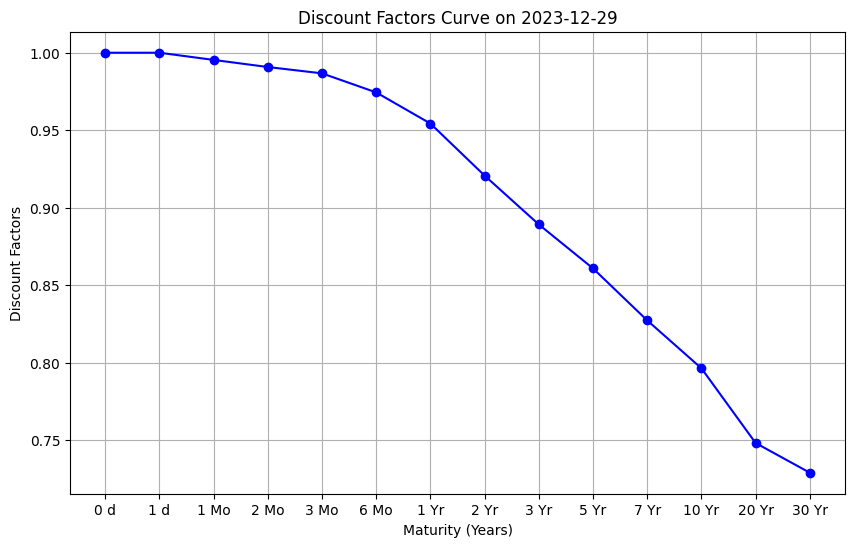

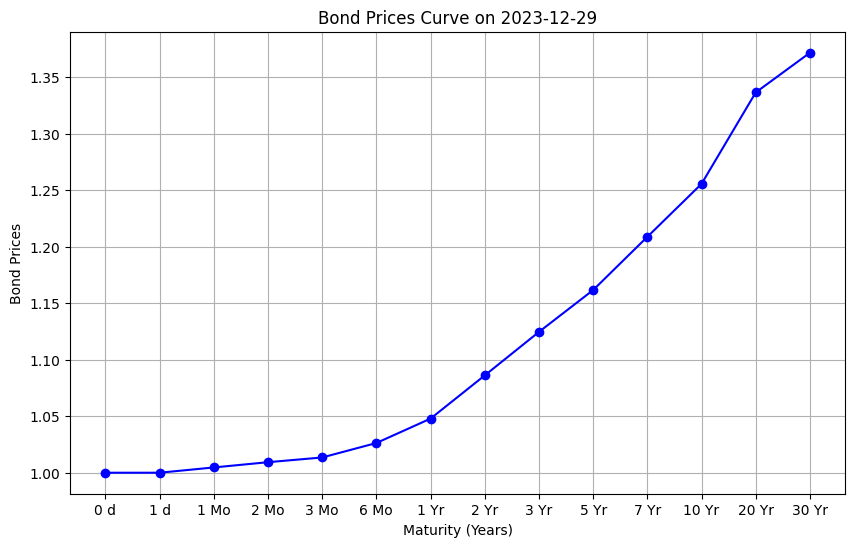

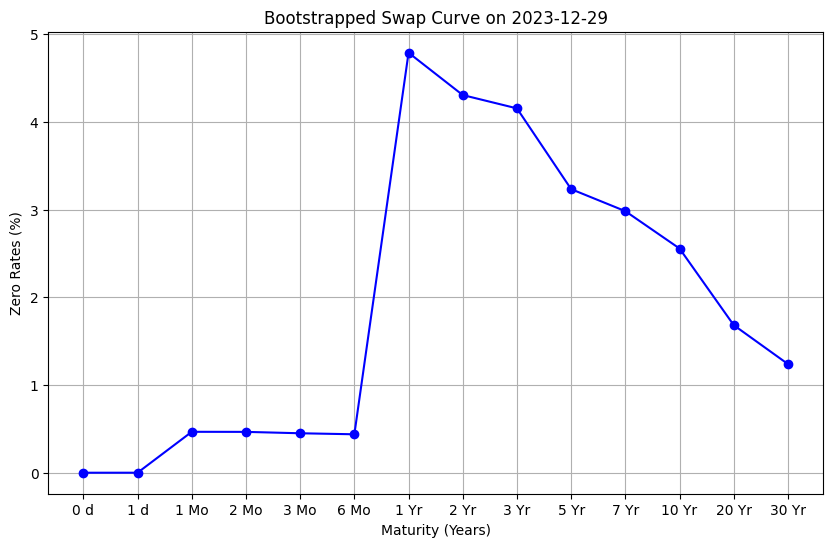

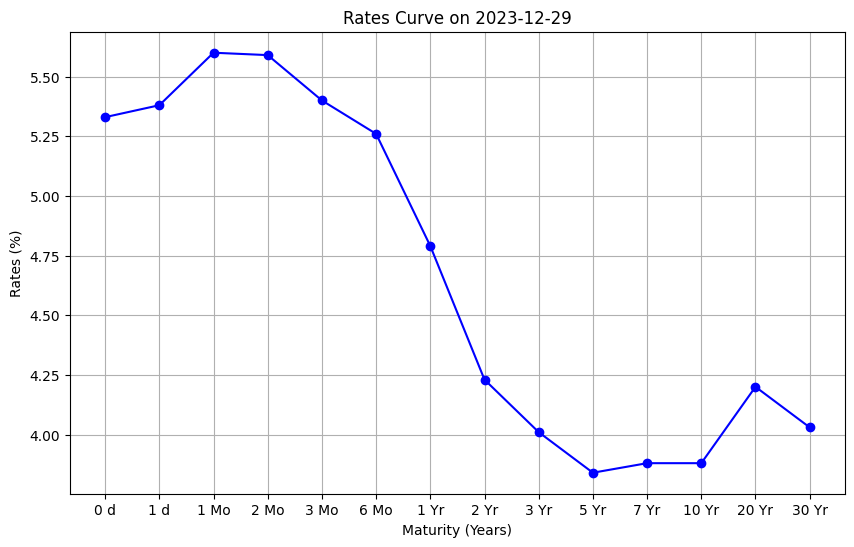

In [44]:
# Plotting the bootstrapped swap curve (zero rates) for a specific date
def plot_curve(df, maturities, date, title, ylabel):
    # Extract the zero rates for the specified date
    zero_rates_list = [df.loc[date, m] for m in maturities]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(maturities, zero_rates_list, marker='o', linestyle='-', color='b')
    plt.title(f'{title} on {date}')
    plt.xlabel('Maturity (Years)')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()


# plot_tenor(fic_data[data.keys()], maturities, '2023-12-29')
# plot_swap_curve(df, maturities, date='2023-12-29')
maturities = [0, 1/365, 1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]  # Maturities in years

plot_curve(discount_factors_df, discount_factors_df.columns.tolist(), '2023-12-29', 'Discount Factors Curve', 'Discount Factors')
plot_curve(bond_prices_df, bond_prices_df.columns.tolist(), '2023-12-29', 'Bond Prices Curve', 'Bond Prices')
plot_curve(bond_yields_df, bond_yields_df.columns.tolist(), '2023-12-29', 'Bootstrapped Swap Curve', 'Zero Rates (%)')
plot_curve(rate_df, rate_df.columns.tolist(), '2023-12-29', 'Rates Curve', 'Rates (%)')

In [7]:
def animate_data(data, maturities, title, xlabel, ylabel, interval=1000, blit=True, save=False, filename='animation.gif', fps=24):
    import matplotlib.animation as animation

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    
    # Initialize the line object
    line, = ax.plot([], [], marker='o', linestyle='-', color='b')
    
    # Set limits dynamically based on maturities (x-axis) and data (y-axis)
    ax.set_xlim(0, max(maturities))  # Assuming maturities are given in years
    ax.set_ylim(data.min().min(), data.max().max())  # Set y-axis based on the min and max of the data
    
    # Update function for the animation
    def update(frame):
        date = data.index[frame]  # Get the current date
        data_list = data.loc[date].fillna(0).values  # Fill NaN values with 0 or interpolate
        
        line.set_data(maturities, data_list)  # Set the new data for the line
        ax.set_title(f'{title} on {date.date()}')  # Update the title with the current date
        return line,
    
    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(data.index), interval=interval, blit=blit)
    progress_callback = lambda i, n: print(f'Saving frame {i}/{n}')
    # Save the animation if needed
    if save:
        ani.save(filename, progress_callback=progress_callback, fps=fps)
    
    # Display the animation
    plt.show()
    plt.close(fig)

maturities = [0, 1/365, 1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]  # Maturities in years


MovieWriter ffmpeg unavailable; using Pillow instead.


Saving frame 0/1438
Saving frame 1/1438
Saving frame 2/1438
Saving frame 3/1438
Saving frame 4/1438
Saving frame 5/1438
Saving frame 6/1438
Saving frame 7/1438
Saving frame 8/1438
Saving frame 9/1438
Saving frame 10/1438
Saving frame 11/1438
Saving frame 12/1438
Saving frame 13/1438
Saving frame 14/1438
Saving frame 15/1438
Saving frame 16/1438
Saving frame 17/1438
Saving frame 18/1438
Saving frame 19/1438
Saving frame 20/1438
Saving frame 21/1438
Saving frame 22/1438
Saving frame 23/1438
Saving frame 24/1438
Saving frame 25/1438
Saving frame 26/1438
Saving frame 27/1438
Saving frame 28/1438
Saving frame 29/1438
Saving frame 30/1438
Saving frame 31/1438
Saving frame 32/1438
Saving frame 33/1438
Saving frame 34/1438
Saving frame 35/1438
Saving frame 36/1438
Saving frame 37/1438
Saving frame 38/1438
Saving frame 39/1438
Saving frame 40/1438
Saving frame 41/1438
Saving frame 42/1438
Saving frame 43/1438
Saving frame 44/1438
Saving frame 45/1438
Saving frame 46/1438
Saving frame 47/1438
Sa

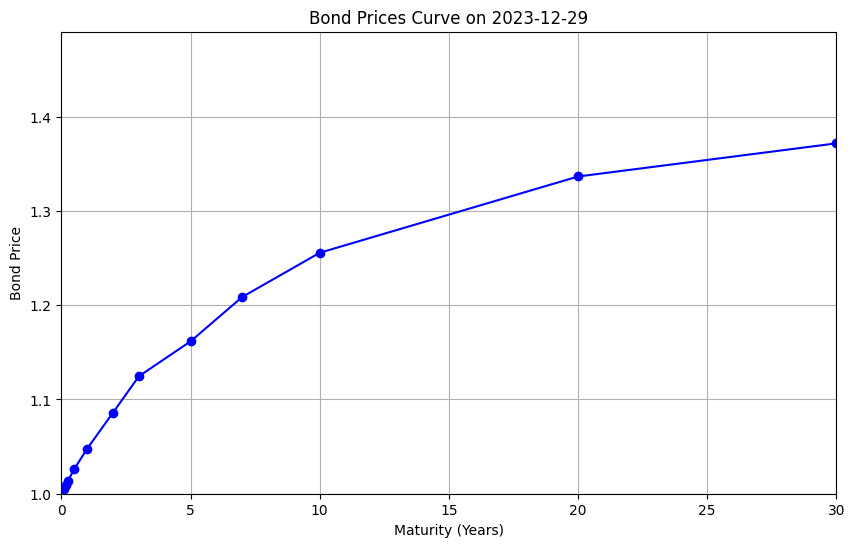

MovieWriter ffmpeg unavailable; using Pillow instead.


Saving frame 0/1438
Saving frame 1/1438
Saving frame 2/1438
Saving frame 3/1438
Saving frame 4/1438
Saving frame 5/1438
Saving frame 6/1438
Saving frame 7/1438
Saving frame 8/1438
Saving frame 9/1438
Saving frame 10/1438
Saving frame 11/1438
Saving frame 12/1438
Saving frame 13/1438
Saving frame 14/1438
Saving frame 15/1438
Saving frame 16/1438
Saving frame 17/1438
Saving frame 18/1438
Saving frame 19/1438
Saving frame 20/1438
Saving frame 21/1438
Saving frame 22/1438
Saving frame 23/1438
Saving frame 24/1438
Saving frame 25/1438
Saving frame 26/1438
Saving frame 27/1438
Saving frame 28/1438
Saving frame 29/1438
Saving frame 30/1438
Saving frame 31/1438
Saving frame 32/1438
Saving frame 33/1438
Saving frame 34/1438
Saving frame 35/1438
Saving frame 36/1438
Saving frame 37/1438
Saving frame 38/1438
Saving frame 39/1438
Saving frame 40/1438
Saving frame 41/1438
Saving frame 42/1438
Saving frame 43/1438
Saving frame 44/1438
Saving frame 45/1438
Saving frame 46/1438
Saving frame 47/1438
Sa

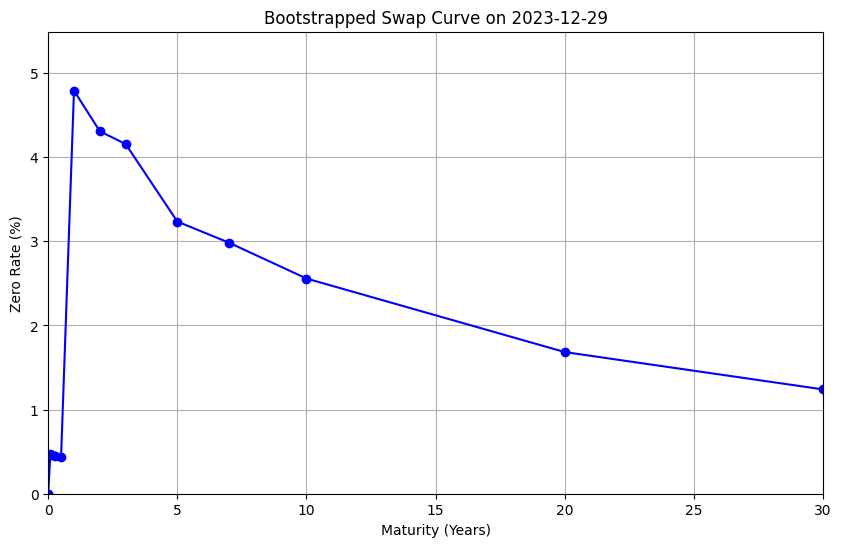

In [8]:
animate_data(bond_prices_df, maturities, 'Bond Prices Curve', 'Maturity (Years)', 'Bond Price', save=True, filename='bond_prices_curve.gif')
animate_data(bond_yields_df, maturities, 'Bootstrapped Swap Curve', 'Maturity (Years)', 'Zero Rate (%)', save=True, filename='bootstrapped_swap_curve.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


Saving frame 0/1438
Saving frame 1/1438
Saving frame 2/1438
Saving frame 3/1438
Saving frame 4/1438
Saving frame 5/1438
Saving frame 6/1438
Saving frame 7/1438
Saving frame 8/1438
Saving frame 9/1438
Saving frame 10/1438
Saving frame 11/1438
Saving frame 12/1438
Saving frame 13/1438
Saving frame 14/1438
Saving frame 15/1438
Saving frame 16/1438
Saving frame 17/1438
Saving frame 18/1438
Saving frame 19/1438
Saving frame 20/1438
Saving frame 21/1438
Saving frame 22/1438
Saving frame 23/1438
Saving frame 24/1438
Saving frame 25/1438
Saving frame 26/1438
Saving frame 27/1438
Saving frame 28/1438
Saving frame 29/1438
Saving frame 30/1438
Saving frame 31/1438
Saving frame 32/1438
Saving frame 33/1438
Saving frame 34/1438
Saving frame 35/1438
Saving frame 36/1438
Saving frame 37/1438
Saving frame 38/1438
Saving frame 39/1438
Saving frame 40/1438
Saving frame 41/1438
Saving frame 42/1438
Saving frame 43/1438
Saving frame 44/1438
Saving frame 45/1438
Saving frame 46/1438
Saving frame 47/1438
Sa

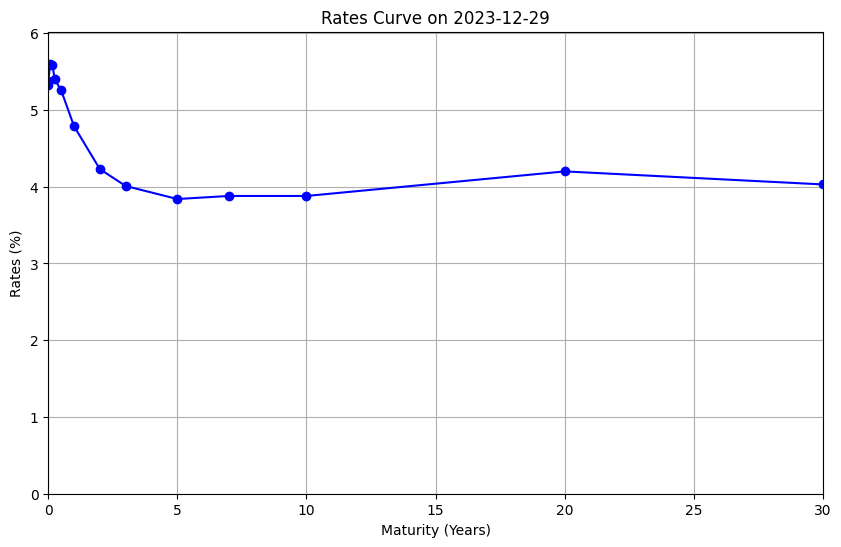

In [50]:
animate_data(rate_df, maturities, 'Rates Curve', 'Maturity (Years)', 'Rates (%)', save=True, filename='rates_curve.gif')

In [51]:
def animate_data(data, maturities, title, xlabel, ylabel, interval=1000, blit=True, save=False, filename='animation.gif', fps=24, secondary_data=None, secondary_label='Secondary Data'):
    import matplotlib.animation as animation

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True)
    
    # Initialize the line objects
    line1, = ax.plot([], [], marker='o', linestyle='-', color='b', label='Swap Curve')
    
    # Initialize the second line if secondary_data is provided
    if secondary_data is not None:
        line2, = ax.plot([], [], marker='o', linestyle='--', color='r', label=secondary_label)
    
    # Set limits dynamically based on maturities (x-axis) and data (y-axis)
    ax.set_xlim(0, max(maturities))  # Assuming maturities are given in years
    ax.set_ylim(min(data.min().min(), secondary_data.min().min()) if secondary_data is not None else data.min().min(), 
                max(data.max().max(), secondary_data.max().max()) if secondary_data is not None else data.max().max())  # Set y-axis limits
    
    # Add a legend
    ax.legend()

    # Update function for the animation
    def update(frame):
        date = data.index[frame]  # Get the current date
        
        # Get data for the primary dataset
        data_list = data.loc[date].fillna(0).values  # Fill NaN values with 0 or interpolate
        
        # Update the first line (swap curve)
        line1.set_data(maturities, data_list)
        
        # If secondary data exists, update the second line
        if secondary_data is not None:
            secondary_data_list = secondary_data.loc[date].fillna(0).values
            line2.set_data(maturities, secondary_data_list)
        
        # Update the title with the current date
        ax.set_title(f'{title} on {date.date()}')
        return (line1, line2) if secondary_data is not None else (line1,)

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(data.index), interval=interval, blit=blit)
    progress_callback = lambda i, n: print(f'Saving frame {i}/{n}')
    
    # Save the animation if needed
    if save:
        ani.save(filename, progress_callback=progress_callback, fps=fps)
    
    # Display the animation
    plt.show()
    plt.close(fig)

MovieWriter ffmpeg unavailable; using Pillow instead.


Saving frame 0/1438
Saving frame 1/1438
Saving frame 2/1438
Saving frame 3/1438
Saving frame 4/1438
Saving frame 5/1438
Saving frame 6/1438
Saving frame 7/1438
Saving frame 8/1438
Saving frame 9/1438
Saving frame 10/1438
Saving frame 11/1438
Saving frame 12/1438
Saving frame 13/1438
Saving frame 14/1438
Saving frame 15/1438
Saving frame 16/1438
Saving frame 17/1438
Saving frame 18/1438
Saving frame 19/1438
Saving frame 20/1438
Saving frame 21/1438
Saving frame 22/1438
Saving frame 23/1438
Saving frame 24/1438
Saving frame 25/1438
Saving frame 26/1438
Saving frame 27/1438
Saving frame 28/1438
Saving frame 29/1438
Saving frame 30/1438
Saving frame 31/1438
Saving frame 32/1438
Saving frame 33/1438
Saving frame 34/1438
Saving frame 35/1438
Saving frame 36/1438
Saving frame 37/1438
Saving frame 38/1438
Saving frame 39/1438
Saving frame 40/1438
Saving frame 41/1438
Saving frame 42/1438
Saving frame 43/1438
Saving frame 44/1438
Saving frame 45/1438
Saving frame 46/1438
Saving frame 47/1438
Sa

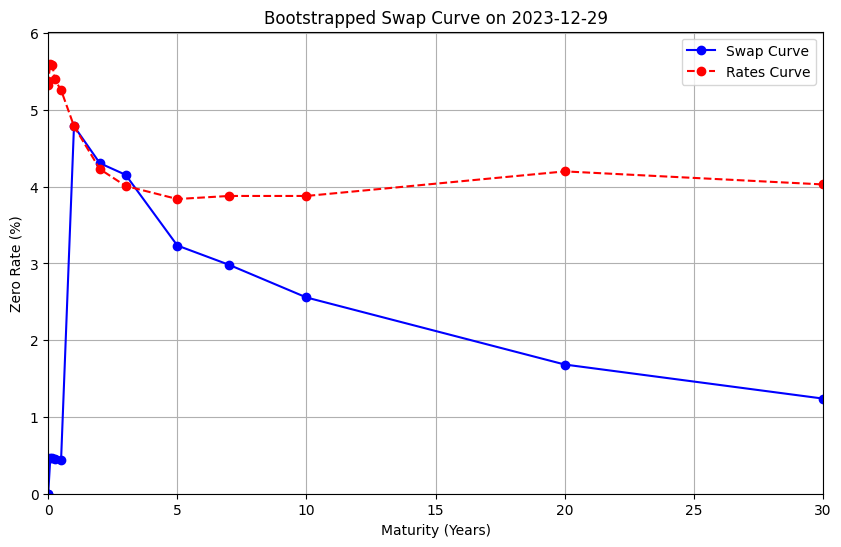

In [52]:
animate_data(bond_yields_df, maturities, 'Bootstrapped Swap Curve', 'Maturity (Years)', 'Zero Rate (%)', save=True, filename='bootstrapped_swap_curve.gif', secondary_data=rate_df, secondary_label='Rates Curve')